## Two Moon Classification with stochastic depth

* We will take the two moon dataset as a dummy dataset that's easy to visualize, and just qualitatively see how the uncertainty boundaries differ compared to dropout.
    * IF the results look good, we'll also try to implement other methods such as Laplace Approximation for visualization

In [24]:
import torch
from torch import nn
from torchvision.ops import StochasticDepth

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

from torch import Tensor
from typing import List, Tuple

### Two Moon dataset

In [66]:
X, Y = make_moons(n_samples=100, shuffle=True, noise=0.1, random_state=1)
X, Y = torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)


def plot_two_moons(X, Y):
    for i in range(len(X)):
        plt.scatter(X[i, 0], X[i, 1], c="orange" if Y[i] == 1 else "green")

### Bayesian Network Wrapper Class

In [23]:
class Bayesian_net(nn.Module):
    """
    Bayesian network class has two internal states, dropout_state and stochastic_depth_state.
    They overwrite the default behaviour of forward pass to enable switching between bayesian and deterministic modes.
    Toggling the states is done by calling set_bayes_mode method.
    """

    def __init__(self) -> None:
        super().__init__()
        self.dropout_state: bool = False
        self.stochastic_depth_state: bool = False

    def _toggle_dropout(self) -> None:
        # override the default behaviour of dropout layers
        if self.dropout_state:
            for m in self.modules():
                if m.__class__.__name__.startswith("Dropout"):
                    m.train()

    def _toggle_stochastic_depth(self) -> None:
        # override the default behaviour of stochastic depth layers
        if self.stochastic_depth_state:
            for m in self.modules():
                if m.__class__.__name__.startswith("StochasticDepth"):
                    m.train()

    def _set_dropout(self, state: bool) -> None:
        self.dropout_state = state

    def _set_stochastic_depth(self, state: bool) -> None:
        self.stochastic_depth_state = state

    def set_bayes_mode(self, state: bool, mode: str) -> None:
        if mode == "dropout":
            self._set_dropout(state)
        elif mode == "stochastic_depth":
            self._set_stochastic_depth(state)
        else:
            print(f"Mode {mode} is not supported.")

    def forward(self, x: Tensor) -> Tensor:
        self._toggle_stochastic_depth()
        self._toggle_dropout()

        return self._forward_impl(x)

    def _forward_impl(self, x: Tensor) -> Tensor:
        raise NotImplementedError

### A simple residual network

In [35]:
class Residual_sd_block(nn.Module):
    def __init__(self, features: int, p: float = 0.5) -> None:
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(features, features), nn.BatchNorm1d(features), nn.ReLU()
        )
        self.p = p
        self.sd = StochasticDepth(p, mode="row")

    def forward(self, x: Tensor) -> Tensor:
        out = self.block(x)
        out = self.sd(out)
        # apply skip connection
        out = x + out
        return out

In [69]:
class Sd_network(Bayesian_net):
    def __init__(self, inp: int, oup: int, N: int, d_feat: int, p=0.5):
        super().__init__()
        self.blocks = nn.Sequential(
            nn.Linear(inp, d_feat),
            nn.BatchNorm1d(d_feat),
            nn.ReLU(),
            *[Residual_sd_block(d_feat, p=p) for _ in range(N)],
            nn.Linear(d_feat, oup),
            nn.Sigmoid()
        )

    def _forward_impl(self, x: Tensor) -> Tensor:
        return self.blocks(x)

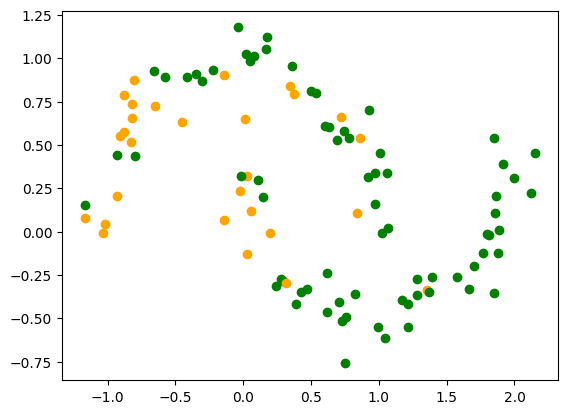

In [76]:
net = Sd_network(2, 1, 10, 5, p=0.5)

linear_layer = nn.Linear(2, 5)
y_pred = net(X) > 0.5

plot_two_moons(X, y_pred)